# Simulation study for homogeneous pairs

Produces Figure 3 in the paper


## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import scipy as sp
import numdifftools as nd # This may need to be installed on your sustem using conda, pip etc.

## Parameters and Initial Conditions

In [2]:
# Starting point for optimiser
lambda_start = 0.007
tau_start = 0.003
initial_guess = np.array([lambda_start, tau_start])

In [3]:
# Initial conditions - normalise to 1
total_pairs = 1760
initial_pairs_ss = 1700
initial_pairs_si = 40
initial_pairs_ii = total_pairs - initial_pairs_ss - initial_pairs_si

# Initial conditions for the solver
initial_state = [initial_pairs_ss, initial_pairs_si, initial_pairs_ii]

## Differential Equations

In [4]:
# Define the differential equations for the epidemic model
def epidemic_model(t, y, lam, tau):
    P_ss, P_si, P_ii = y
    dP_ss = - 2 * lam* P_ss
    dP_si = 2 * lam* P_ss - lam* P_si - tau * P_si
    dP_ii = lam* P_si + tau * P_si
    return [dP_ss, dP_si, dP_ii]

## Simulation Settings

In [5]:
T = 2.0
trange = np.linspace(0, T, 2)  # 2 data points
n = 1760 # Samples taken at each timepoint

## Log-Likelihood Function

In [6]:
# Log-likelihood function
def myll(lam, tau, z):
    odefun = lambda t, x: epidemic_model(t, x, lam, tau)
    sol = solve_ivp(odefun, (0, T), initial_state, t_eval=trange)
    pp = (sol.y / total_pairs).T
    ll = np.sum(sp.stats.multinomial.logpmf(z, n, pp))
    return ll

In [7]:
# Define the negative log-likelihood
def neg_log_likelihood(params, z):
    return -myll(params[0], params[1], z)

## Synthetic Data Generator

In [8]:
# Function to generate synthetic data
def generate_synthetic_data(lambda_true, tau_true):
    odefun_true = lambda t, x: epidemic_model(t, x, lambda_true, tau_true)
    sol = solve_ivp(odefun_true, (0, T), initial_state, t_eval=trange)
    z = np.zeros((len(trange), 3))
    np.random.seed(123)
    for i, t in enumerate(trange):
        z[i, :] = sp.stats.multinomial.rvs(n, sol.y[:, i] / total_pairs)
    return z

## Parameter Inference

In [9]:
# Function to infer parameters given synthetic data z
def infer_parameters(lambda_true, tau_true, z):
    # Estimate parameters using synthetic data z
    initial_guess = np.array([0.1, 0.1])  # or some other starting point
    result = minimize(neg_log_likelihood, initial_guess, args=(z,), method='Nelder-Mead')
    xhat = result.x  # Estimated parameters
    
    # Compute Hessian
    hess_func = nd.Hessian(lambda params: neg_log_likelihood(params, z))
    hessian_matrix = hess_func(xhat)
    
    # Compute covariance matrix
    cov_matrix = np.linalg.inv(hessian_matrix)
    
    # Compute standard deviations and confidence intervals
    stds = np.sqrt(np.diag(cov_matrix))
    ci_lower = xhat - 1.96 * stds
    ci_upper = xhat + 1.96 * stds
    
    return xhat[0], xhat[1], ci_lower[0], ci_upper[0], ci_lower[1], ci_upper[1]

## Parameter Grid Search

In [10]:
# Define a range of true values for lambda and tau
deltal = 0.1
deltat = 0.075
lambda_values = np.arange(0.1,0.6,deltal)
tau_values = np.arange(0.1,0.41,deltat)

In [11]:
# Store results
true_lambdas, est_lambdas, true_taus, est_taus = [], [], [], []
ci_lambda_low, ci_lambda_high = [], []
ci_tau_low, ci_tau_high = [], []

In [12]:
# Loop over all combinations of true lambda and tau
for lambda_true in lambda_values:
    for tau_true in tau_values:
        z = generate_synthetic_data(lambda_true, tau_true)
        est_lambda, est_tau, ci_l_low, ci_l_high, ci_t_low, ci_t_high = infer_parameters(lambda_true, tau_true, z)
        
        # Store values
        true_lambdas.append(lambda_true)
        est_lambdas.append(est_lambda)
        true_taus.append(tau_true)
        est_taus.append(est_tau)
        ci_lambda_low.append(ci_l_low)
        ci_lambda_high.append(ci_l_high)
        ci_tau_low.append(ci_t_low)
        ci_tau_high.append(ci_t_high)


true_lambdas = np.array(true_lambdas)
est_lambdas = np.array(est_lambdas)
true_taus = np.array(true_taus)
est_taus = np.array(est_taus)
ci_lambda_low = np.array(ci_lambda_low)
ci_lambda_high = np.array(ci_lambda_high)
ci_tau_low = np.array(ci_tau_low)
ci_tau_high = np.array(ci_tau_high)

## Plotting

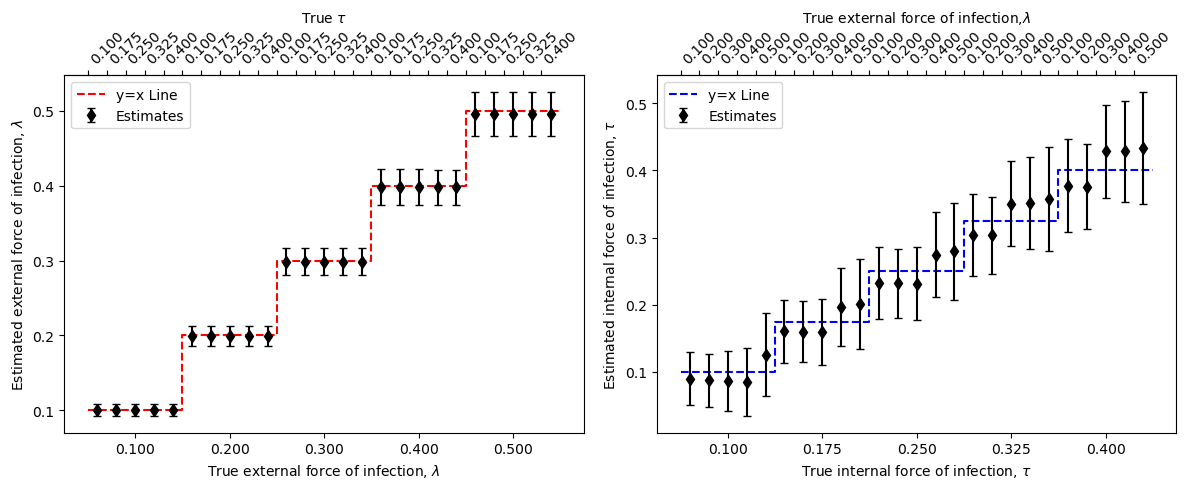

In [13]:
# Plot results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#lambda plot
axes[0].step(
    np.append(lambda_values,lambda_values[-1]+deltal),
    np.append(lambda_values,lambda_values[-1]),
    'r--',
    label="y=x Line",
    where='post')
axes[0].set_xticks(lambda_values + (deltal/2))
axes[0].set_xticklabels(['{:0.3f}'.format(ll) for ll in lambda_values])

for i, true_lambda in enumerate(lambda_values):
    indices = [j for j, x in enumerate(true_lambdas) if x == true_lambda]
    est_vals = [est_lambdas[j] for j in indices]
    ci_lows = [ci_lambda_low[j] for j in indices]
    ci_highs = [ci_lambda_high[j] for j in indices]

    x_pos = true_lambda + ((true_taus[indices] + 0.5*deltat - true_taus[0])/(true_taus[-1] + deltat - true_taus[0]))*(deltal)
    
    axes[0].errorbar(x_pos, est_vals, yerr=[np.array(est_vals) - np.array(ci_lows), 
                                            np.array(ci_highs) - np.array(est_vals)], 
                      fmt='d', color='black', ecolor='black', capsize=3, label="Estimates" if i == 0 else "")

secax = axes[0].secondary_xaxis('top')
secax.set_xticks(true_lambdas + (true_taus - true_taus[0])*(deltal)/(true_taus[-1] + deltat - true_taus[0]))
secax.set_xticklabels(['{:0.3f}'.format(tt) for tt in true_taus], rotation=45, ha = 'left')

#tau plot
axes[1].step(
    np.append(tau_values,tau_values[-1]+deltat),
    np.append(tau_values,tau_values[-1]),
    'b--',
    label="y=x Line",
    where='post')
axes[1].set_xticks(tau_values + (deltat/2))
axes[1].set_xticklabels(['{:0.3f}'.format(ll) for ll in tau_values])

for i, true_tau in enumerate(tau_values):
    indices = [j for j, x in enumerate(true_taus) if x == true_tau]
    est_vals = [est_taus[j] for j in indices]
    ci_lows = [ci_tau_low[j] for j in indices]
    ci_highs = [ci_tau_high[j] for j in indices]

    x_pos = true_tau + (true_lambdas[indices] + 0.5*deltal - true_lambdas[0])*(deltat)/(true_lambdas[-1] + deltal - true_lambdas[0])
    
    axes[1].errorbar(x_pos, est_vals, yerr=[np.array(est_vals) - np.array(ci_lows), 
                                            np.array(ci_highs) - np.array(est_vals)], 
                      fmt='d', color='black', ecolor='black', capsize=3, label="Estimates" if i == 0 else "")

secax2 = axes[1].secondary_xaxis('top')
secax2.set_xticks(true_taus + (true_lambdas - true_lambdas[0])*(deltat)/(true_lambdas[-1] + deltal - true_lambdas[0]))
secax2.set_xticklabels(['{:0.3f}'.format(ll) for ll in true_lambdas], rotation=45, ha = 'left')

secax.set_xlabel(r'True $\tau$')
axes[0].set_xlabel(r'True external force of infection, $\lambda$')
axes[0].set_ylabel(r'Estimated external force of infection, $\lambda$')
secax2.set_xlabel(r'True external force of infection,$\lambda$')
axes[1].set_xlabel(r'True internal force of infection, $\tau$')
axes[1].set_ylabel(r'Estimated internal force of infection, $\tau$')

axes[0].legend()
axes[1].legend()

fig.tight_layout()

plt.savefig('./Figure3.pdf')